# Modelos
- Observações:
    - A variável target não segue uma disttribuição normal
    - As variáveis possuem outliers
    - O correto seria desenvover cada modelo isoladamente, analisando as suas susposições, fazendo alguns tratamento para lidar com a distribuição não normal e assim por diante. Mas levaria muito tempo e acabei optando por utilizar o H2o AutoML.

In [30]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import h2o
from h2o.automl import H2OAutoML
import pickle

In [31]:
# Carrega os dados 
df = pd.read_csv('/Users/erichenriquedasilvapassos/Downloads/Rank_My_App/data/df_tratado.csv')
df.head(5)

,dauReal_daumau,mauReal_daumau,predictionLoss_desinstalacoes,newinstalls_installs,ratings_ratings_reviews,daily_ratings_ratings_reviews,reviews_ratings_reviews,daily_reviews_ratings_reviews,category_BUSINESS,category_FINANCE,category_FOOD_AND_DRINK,category_OTHERS,category_SHOPPING,category_TRAVEL_AND_LOCAL
0,223700.0,1950503.0,30372.0,4064.0,418299.0,210.0,111173.0,88.0,False,True,False,False,False,False
1,826841.0,2667280.0,30033.0,3038.0,423868.0,37.0,46972.0,27.0,False,True,False,False,False,False
2,10149.0,77387.0,1569.0,881.0,62744.0,1.0,26406.0,1.0,False,True,False,False,False,False
3,777969.0,5880590.0,37538.0,24465.0,1242231.0,149.0,584161.0,136.0,False,True,False,False,False,False
4,11466.0,107133.0,1166.0,966.0,8363.0,0.0,4708.0,0.0,False,True,False,False,False,False


In [32]:
# Variáveis preditoras
colunas = [col for col in df.columns if col != "dauReal_daumau"]
x = df[colunas]

In [33]:
# Variável de saída (Target)
y = df['dauReal_daumau']

In [34]:
# Divisão em dados de treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.3, random_state = 101)

In [35]:
x_teste.shape

(55, 13)

In [36]:
# Criando a instância de uma classe
scaler = StandardScaler()

# Treina o padronizador com dados de treino
scaler.fit(x_treino)

# Aplica o padronizador aos dados de treino e de teste
x_treino = scaler.transform(x_treino)
x_teste = scaler.transform(x_teste)

In [37]:
!pip install h2o



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [38]:
# Inicializa o H2O
h2o.init()

# Cria DataFrames pandas para o H2O
x_treino_df = pd.DataFrame(x_treino, columns=x.columns)
y_treino_df = pd.DataFrame(y_treino, columns=[y.name])  # y.name é o nome da coluna alvo
train_df = pd.concat([x_treino_df, y_treino_df], axis=1)

x_teste_df = pd.DataFrame(x_teste, columns=x.columns)
y_teste_df = pd.DataFrame(y_teste, columns=[y.name])  # y.name é o nome da coluna alvo
test_df = pd.concat([x_teste_df, y_teste_df], axis=1)

# Transforma os DataFrames do pandas para H2O Frames
train_h2o = h2o.H2OFrame(train_df)
test_h2o = h2o.H2OFrame(test_df)

# Define a coluna alvo e as features
target = y.name
features = x.columns.tolist()

# Configura e treina o AutoML
aml = H2OAutoML(max_models=15, seed=1)
aml.train(x=features, y=target, training_frame=train_h2o)

# Previsões no conjunto de teste
predictions = aml.leader.predict(test_h2o)

# Avaliação do desempenho do modelo no conjunto de teste
performance = aml.leader.model_performance(test_h2o)
print(performance)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 0 mins
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,1 month and 25 days
H2O_cluster_name:,H2O_from_python_erichenriquedasilvapassos_uripqv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.948 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
08:47:05.72: AutoML: XGBoost is not available; skipping it.
08:47:05.240: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 165.0.

███████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 593217235513.1934
RMSE: 770205.9695387938
MAE: 491427.1411652842
RMSLE: 3.5134098709923376
Mean Residual Deviance: 593217235513.1934


In [39]:
# Exibe o leaderboard com todos os modelos treinados
leaderboard = aml.leaderboard
print(leaderboard)

model_id                                                       rmse          mse     mae      rmsle    mean_residual_deviance
GBM_3_AutoML_3_20241025_84705                           1.09448e+06  1.19788e+12  572647  nan                     1.19788e+12
GLM_1_AutoML_3_20241025_84705                           1.09649e+06  1.2023e+12   579654    3.20975               1.2023e+12
StackedEnsemble_BestOfFamily_1_AutoML_3_20241025_84705  1.09693e+06  1.20326e+12  586360    3.23044               1.20326e+12
GBM_2_AutoML_3_20241025_84705                           1.10105e+06  1.21231e+12  582346  nan                     1.21231e+12
GBM_grid_1_AutoML_3_20241025_84705_model_3              1.1021e+06   1.21462e+12  564231  nan                     1.21462e+12
GBM_4_AutoML_3_20241025_84705                           1.103e+06    1.21661e+12  569842  nan                     1.21661e+12
StackedEnsemble_AllModels_1_AutoML_3_20241025_84705     1.10463e+06  1.2202e+12   575250    3.1923                1.220

In [40]:
# Mais detalhes, como todas as colunas do leaderboard
leaderboard_df = leaderboard.as_data_frame()
print(leaderboard_df)

                                             model_id          rmse  \
0                       GBM_3_AutoML_3_20241025_84705  1.094477e+06   
1                       GLM_1_AutoML_3_20241025_84705  1.096493e+06   
2   StackedEnsemble_BestOfFamily_1_AutoML_3_202410...  1.096930e+06   
3                       GBM_2_AutoML_3_20241025_84705  1.101049e+06   
4          GBM_grid_1_AutoML_3_20241025_84705_model_3  1.102098e+06   
5                       GBM_4_AutoML_3_20241025_84705  1.103002e+06   
6   StackedEnsemble_AllModels_1_AutoML_3_20241025_...  1.104629e+06   
7   DeepLearning_grid_3_AutoML_3_20241025_84705_mo...  1.114434e+06   
8          GBM_grid_1_AutoML_3_20241025_84705_model_1  1.115447e+06   
9   DeepLearning_grid_1_AutoML_3_20241025_84705_mo...  1.132895e+06   
10  DeepLearning_grid_2_AutoML_3_20241025_84705_mo...  1.134192e+06   
11             DeepLearning_1_AutoML_3_20241025_84705  1.144891e+06   
12                      XRT_1_AutoML_3_20241025_84705  1.148076e+06   
13    

/Users/erichenriquedasilvapassos/Downloads/Rank_My_App/.venv/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [41]:
# O melhor modelo
best_model = aml.leader
print(best_model)

# Detalhes do modelo
print(best_model.params)


Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_3_AutoML_3_20241025_84705


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    23                 23                          3153                   3            6            4.08696       5             8             6.30435

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 970018373876.9517
RMSE: 984895.1080581889
MAE: 506234.71788194444
RMSLE: 3.01032495077279
Mean Residual Deviance: 970018373876.9517

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 1197880285571.0645
RMSE: 1094477.174531778
MAE: 572647.022143943
RMSLE: NaN
Mean Residual Deviance: 1197880285571.0645

Cross-Validation 

In [42]:
# Extraindo as métricas de desempenho
perf = best_model.model_performance()

# Acessando as métricas específicas
rmse = perf.rmse()
mae = perf.mae()
mse = perf.mse()
r2 = perf.r2()

# Exibindo as métricas
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")


RMSE: 984895.1080581889
MAE: 506234.71788194444
MSE: 970018373876.9517
R²: 0.18877879293250555


In [43]:
# Importância das features
feature_importance = best_model.varimp(use_pandas=True)
#print(feature_importance)


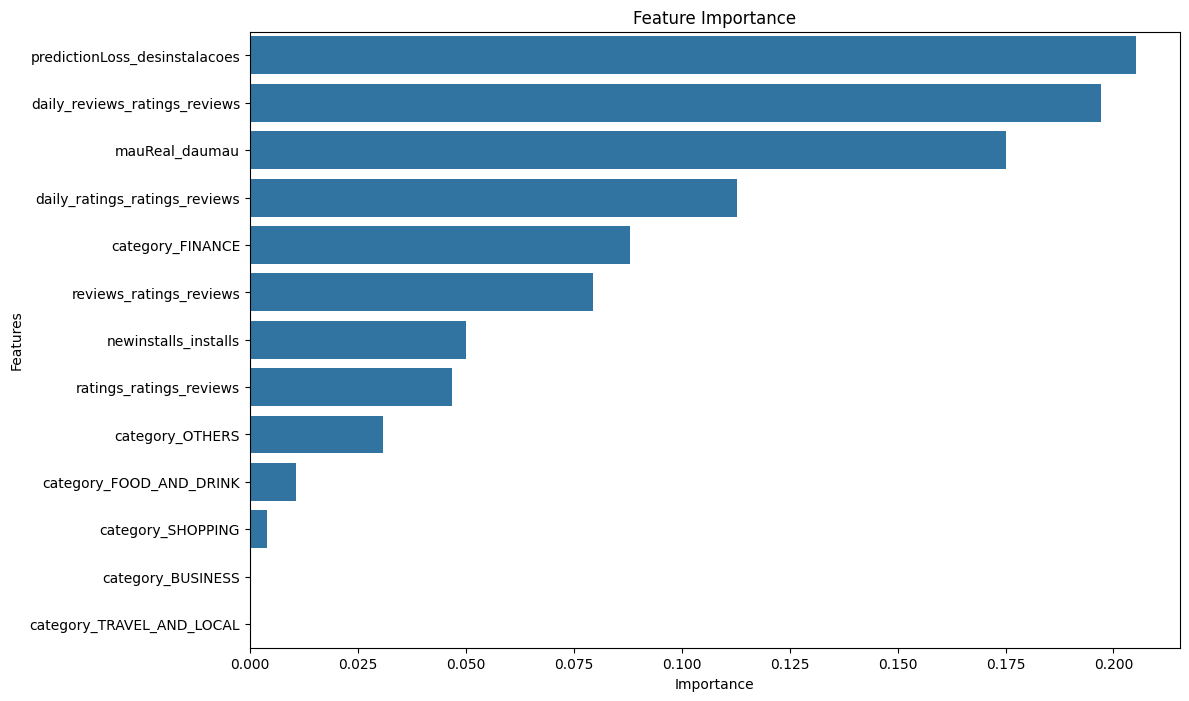

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot de Importância das Features
plt.figure(figsize=(12, 8))
sns.barplot(x='percentage', y='variable', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


In [47]:

# Salvar o modelo H2O
#h2o.save_model(model=best_model, path='/Users/erichenriquedasilvapassos/Downloads/Rank_My_App/models/', force=True)


'/Users/erichenriquedasilvapassos/Downloads/Rank_My_App/models/GBM_3_AutoML_3_20241025_84705'

In [51]:

# Configurações
model_params = {
    'model_id': best_model.model_id,
    'model_parameters': best_model.params,
    'training_frame': best_model.training_frame
}

# Salvar com pickle
with open('/Users/erichenriquedasilvapassos/Downloads/Rank_My_App/models/pkl_model.pkl', 'wb') as f:
    pickle.dump(model_params, f)



# Sobre os resultados:
- Olhando apenas para o R² de 0.1888 podemos concluir que;
um R² de 0.1888 é relativamente baixo. Isso significa que apenas cerca de 18.88% da variabilidade dos dados pode ser explicada pelo modelo. Em geral, um R² abaixo de 0.2 é considerado um sinal de que o modelo não está capturando bem a relação entre as variáveis preditoras e a variável alvo. Isso pode indicar que o modelo não é adequado ou que faltam variáveis importantes.